<a href="https://colab.research.google.com/github/ipediz/BachehayekhafaneTMU/blob/main/Ridge_and_Lasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This code was written with the aid of ChatGPT**

In [ ]:
!pip install ISLP l0bnb

import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
import sklearn.linear_model as skl
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import enet_path
from functools import partial
from sklearn.preprocessing import StandardScaler  # Import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
from l0bnb import fit_path
import statsmodels.api as sm

In [ ]:
Data = pd.read_csv("All_STATE_CASUAL_READY_2.csv")
Data['percent_over_60'] = Data['percent_over_60'] / 100
# setting 'county_code' as index and 'new_timeperiod' as time



In [ ]:
from tabulate import tabulate
#dropping non-relative variables for summary statistics table
columns_to_drop = [
    'relative_time_m8andbeyond', 'relative_time_m7', 'relative_time_m6', 'relative_time_m5',
    'relative_time_m4', 'relative_time_m3', 'relative_time_m2', 'relative_time_m1', 'relative_time_0',
    'relative_time_p1', 'relative_time_p2', 'relative_time_p3', 'relative_time_p4',
    'relative_time_p5', 'relative_time_p6', 'relative_time_p7', 'relative_time_p8andbeyond', 'business_bankruptcy_percapita', 'nonbusiness_bankruptcy_percapita',
 'cem_strata', 'cem_weights', 'log_bankruptcy', 'county_code', 'new_timeperiod', 'interaction'
]

# Create a new dataframe without the specified columns
Data1 = Data.drop(columns=columns_to_drop)
Data1 = Data1.dropna()

In [ ]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

In [ ]:
design = MS(Data1.columns.drop('bankruptcy_per_capita')).fit(Data1)
Y = np.array(Data1['bankruptcy_per_capita'])
X = design.transform(Data1)
sigma2 = sm.OLS(Y,X).fit().scale


In [ ]:
neg_Cp = partial(nCp, sigma2)

In [ ]:
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

In [ ]:
Data1_MSE = sklearn_selected(sm.OLS,
                               strategy)
Data1_MSE.fit(Data1, Y)
Data1_MSE.selected_state_


('Treatment',
 'employed_individuals',
 'labor_force',
 'lending_club_available',
 'medianhouseholdincome',
 'monthly_earnings',
 'percent_over_60',
 'population_estimation')

In [ ]:
Data1_Cp = sklearn_selected(sm.OLS,
                               strategy,
                               scoring=neg_Cp)
Data1_Cp.fit(Data1, Y)
Data1_Cp.selected_state_


('Treatment',
 'employed_individuals',
 'labor_force',
 'lending_club_available',
 'medianhouseholdincome',
 'monthly_earnings',
 'percent_over_60',
 'population_estimation')

In [ ]:
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction='forward')
full_path = sklearn_selection_path(sm.OLS, strategy)

Latex Output


In [ ]:
full_path.fit(Data1, Y)
Yhat_in = full_path.predict(Data1)
Yhat_in.shape

(64428, 9)

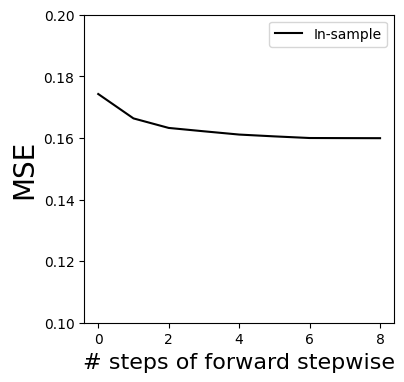

In [ ]:
mse_fig, ax = subplots(figsize=(4,4))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE',
              fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
              fontsize=16)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([0.1,0.2]);


In [ ]:
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path,
                                Data1,
                                Y,
                                cv=kfold)
Yhat_cv.shape

(64428, 9)

In [ ]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx,None])**2
    cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape

(9, 5)

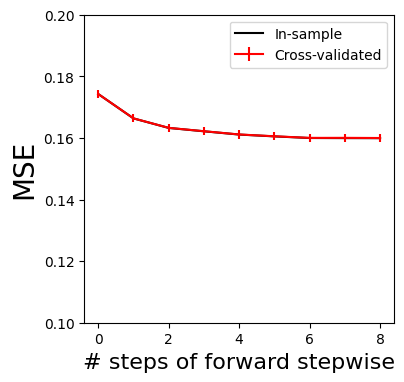

In [ ]:
ax.errorbar(np.arange(n_steps),
            cv_mse.mean(1),
            cv_mse.std(1) / np.sqrt(K),
            label='Cross-validated',
            c='r') # color red
ax.set_ylim([0.1,0.200])
ax.legend()
mse_fig

In [ ]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.2,
                              random_state=0)
for train_idx, test_idx in validation.split(Y):
    full_path.fit(Data1.iloc[train_idx],
                  Y[train_idx])
    Yhat_val = full_path.predict(Data1.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx,None])**2
    validation_mse = errors.mean(0)


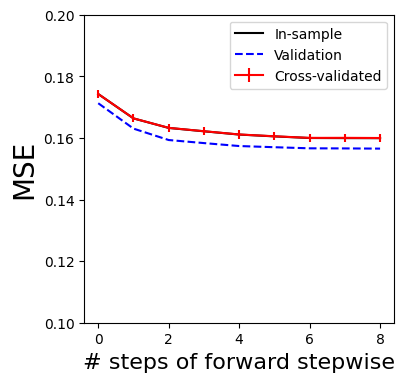

In [ ]:
ax.plot(np.arange(n_steps),
        validation_mse,
        'b--', # color blue, broken line
        label='Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([0.1,0.20])
ax.legend()
mse_fig


In [ ]:
D = design.fit_transform(Data1)
D = D.drop('intercept', axis=1)
X = np.asarray(D)


In [ ]:
path = fit_path(X,
                Y,
                max_nonzeros=X.shape[1])


Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  1
Iteration: 3. Number of non-zeros:  1
Iteration: 4. Number of non-zeros:  1
Iteration: 5. Number of non-zeros:  1
Iteration: 6. Number of non-zeros:  1
Iteration: 7. Number of non-zeros:  1
Iteration: 8. Number of non-zeros:  1
Iteration: 9. Number of non-zeros:  1
Iteration: 10. Number of non-zeros:  1
Iteration: 11. Number of non-zeros:  1
Iteration: 12. Number of non-zeros:  1
Iteration: 13. Number of non-zeros:  1
Iteration: 14. Number of non-zeros:  1
Iteration: 15. Number of non-zeros:  3
Iteration: 16. Number of non-zeros:  3
Iteration: 17. Number of non-zeros:  3
Iteration: 18. Number of non-zeros:  3
Iteration: 19. Number of non-zeros:  3
Iteration: 20. Number of non-zeros:  3
Iteration: 21. Number of non-zeros:  3
Iteration: 22. Number of non-zeros:  3
Iteration: 23. Number of non-zeros:  3
Iteration: 24. Number of non-zeros:  3
Iteration: 25. Number of non-zeros:  3
I

In [ ]:
path[3]

{'B': array([0.        , 0.00103916, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]),
 'B0': 0.5953545261204594,
 'lambda_0': 0.006614617975655917,
 'M': 0.25077567902533743,
 'Time_exceeded': False}

In [ ]:
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
soln_array.shape

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19376.446538559583, tolerance: 3.8752893083306295
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective di

(8, 100)

In [ ]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path


,lending_club_available,population_estimation,employed_individuals,monthly_earnings,labor_force,medianhouseholdincome,percent_over_60,Treatment
negative log(lambda),,,,,,,,
-19.294296,6.391542e-12,3.714430e-10,2.961827e-10,-7.841351e-11,3.674323e-10,8.427490e-11,-1.639189e-10,-3.525528e-12
-19.061711,8.065211e-12,4.687079e-10,3.737402e-10,-9.894663e-11,4.636470e-10,1.063429e-10,-2.068421e-10,-4.448712e-12
-18.829127,1.017714e-11,5.914423e-10,4.716067e-10,-1.248565e-10,5.850561e-10,1.341895e-10,-2.610052e-10,-5.613637e-12
-18.596542,1.284210e-11,7.463155e-10,5.951001e-10,-1.575510e-10,7.382571e-10,1.693279e-10,-3.293512e-10,-7.083606e-12
-18.363958,1.620489e-11,9.417434e-10,7.509312e-10,-1.988068e-10,9.315748e-10,2.136676e-10,-4.155941e-10,-8.938497e-12
...,...,...,...,...,...,...,...,...
2.801218,-2.813325e-03,7.169384e-02,-4.429859e-02,-5.588580e-02,6.972189e-02,1.428435e-02,-4.778924e-02,2.754059e-02
3.033802,-3.251835e-03,7.540976e-02,-5.288811e-02,-5.648610e-02,7.508419e-02,1.438795e-02,-4.881786e-02,2.852634e-02
3.266387,-3.665474e-03,7.858369e-02,-6.138296e-02,-5.686724e-02,8.077579e-02,1.436599e-02,-4.965758e-02,2.934142e-02


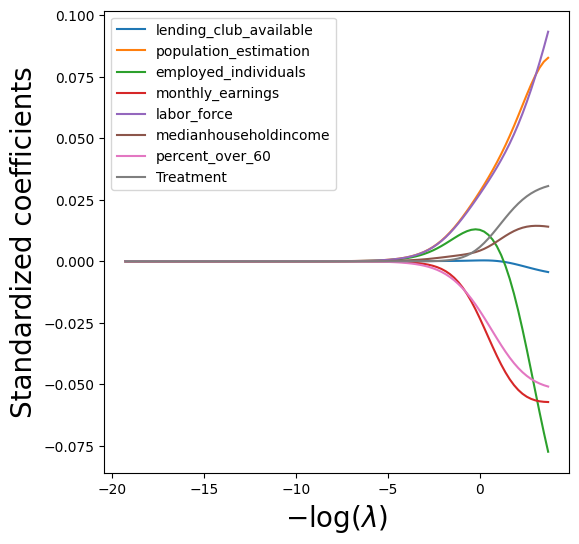

In [ ]:
path_fig, ax = subplots(figsize=(6,6))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left');

In [ ]:
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat


(27543.05673233489,
 lending_club_available    5.557542e-08
 population_estimation     3.230299e-06
 employed_individuals      2.575730e-06
 monthly_earnings         -6.821127e-07
 labor_force               3.195414e-06
 medianhouseholdincome     7.328500e-07
 percent_over_60          -1.425623e-06
 Treatment                -3.063287e-08
 Name: -10.223505758582949, dtype: float64)

In [ ]:
np.linalg.norm(beta_hat)


5.506238674950868e-06

In [ ]:
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)


(262.9118229559963, 0.0005709930857373511)

In [ ]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True,  with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.611e+03, tolerance: 1.123e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=262.9118229559963, l1_ratio=0))])

In [ ]:
np.linalg.norm(ridge.coef_)

0.0005709930857373522

In [ ]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.5,
                              random_state=0)
ridge.alpha = 0.01
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.591e+03, tolerance: 5.580e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([0.16248525])

In [ ]:
ridge.alpha = 1e10
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.790e+03, tolerance: 5.580e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([0.17528116])

In [ ]:
param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=validation,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.790e+03, tolerance: 5.580e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.790e+03, tolerance: 5.580e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.0239555461219933, l1_ratio=0))])

In [ ]:
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.510e+03, tolerance: 9.020e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.453e+03, tolerance: 8.906e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.0239555461219933, l1_ratio=0))])

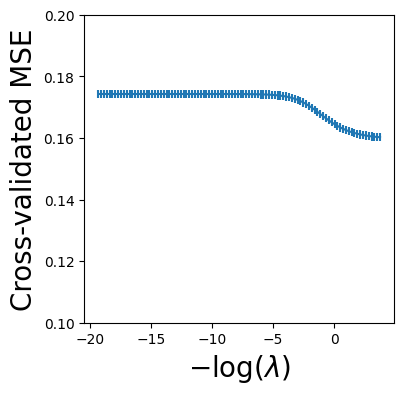

In [ ]:
ridge_fig, ax = subplots(figsize=(4,4))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr= (grid.cv_results_['std_test_score'] / np.sqrt(K)))
ax.set_ylim([0.10,0.20])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);


In [ ]:
grid_r2 = skm.GridSearchCV(pipe,
                           param_grid,
                           cv=kfold)
grid_r2.fit(X, Y)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.510e+03, tolerance: 9.020e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.453e+03, tolerance: 8.906e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        ElasticNet(alpha=10000000000.0,
                                                   l1_ratio=0))]),
             param_grid={'ridge__alpha': array([2.39555461e+08, 1.89843606e+08, 1.50447811e+08, 1.19227318e+08,
       9.44856102e+07, 7.48782302e+07, 5.93397169e+07, 4.70257108e+07,
       3.72670716e+07, 2.95335169...
       5.04241283e+00, 3.99602594e+00, 3.16678222e+00, 2.50962075e+00,
       1.98883152e+00, 1.57611497e+00, 1.24904416e+00, 9.89846136e-01,
       7.84436135e-01, 6.21652222e-01, 4.92648755e-01, 3.90415713e-01,
       3.09397776e-01, 2.45192446e-01, 1.94310820e-01, 1.53988002e-01,
       1.22032858e-01, 9.67089531e-02, 7.66401915e-02, 6.07360411e-02,
       4.81322739e-02, 3.81440039e-02, 3.02284708e-02, 2.39555461e-02])})

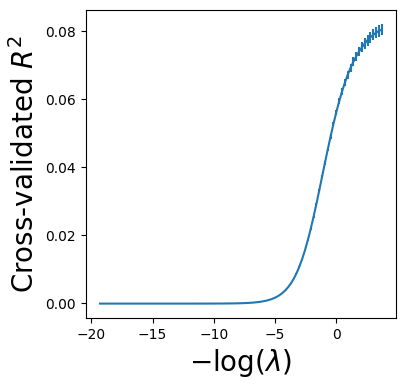

In [ ]:
r2_fig, ax = subplots(figsize=(4,4))
ax.errorbar(-np.log(lambdas),
            grid_r2.cv_results_['mean_test_score'],
            yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated $R^2$', fontsize=20);

In [ ]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X, Y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4510.041153533126, tolerance: 0.902008231197198
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did 

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.39555461e+08, 1.89843606e+08, 1.50447811e+08, 1.19227318e+08,
       9.44856102e+07, 7.48782302e+07, 5.93397169e+07, 4.70257108e+07,
       3.72670716e+07, 2.95335169e+07, 2.34048071e+07, 1.85479094e+07,
       1.46989010e+07, 1.16486276e+07, 9.23133820e+06, 7.31567765e+06,
       5.79754943e+06, 4.59445877e+06,...
       1.98883152e+00, 1.57611497e+00, 1.24904416e+00, 9.89846136e-01,
       7.84436135e-01, 6.21652222e-01, 4.92648755e-01, 3.90415713e-01,
       3.09397776e-01, 2.45192446e-01, 1.94310820e-01, 1.53988002e-01,
       1.22032858e-01, 9.67089531e-02, 7.66401915e-02, 6.07360411e-02,
       4.81322739e-02, 3.81440039e-02, 3.02284708e-02, 2.39555461e-02]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

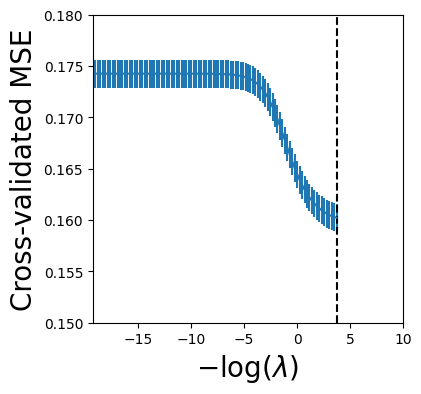

In [ ]:
tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig, ax = subplots(figsize=(4,4))
ax.errorbar(-np.log(lambdas),
            tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_ylim([0.15,0.18])
ax.set_xlim([min(-np.log(lambdas)), 10])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [ ]:
np.min(tuned_ridge.mse_path_.mean(1))

0.16023269095369636

In [ ]:
tuned_ridge.coef_

array([-0.00438582,  0.0826102 , -0.07734167, -0.05716298,  0.09320023,
        0.01403409, -0.05087312,  0.03054171])

In [ ]:
from sklearn.linear_model import LassoCV


In [ ]:
lambdas = np.logspace(-4, 4, 100)
lasso = LassoCV(alphas=lambdas, cv=5).fit(Xs, Y)


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
print("Lasso Coefficients:", lasso.coef_)


Lasso Coefficients: [-0.00409924  0.01711034 -0.12108779 -0.0550655   0.203476    0.007918
 -0.05084285  0.03013841]


In [ ]:
outer_valid = skm.ShuffleSplit(n_splits=1,
                               test_size=0.25,
                               random_state=1)
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=2)
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)]);


In [ ]:
results = skm.cross_validate(pipeCV,
                             X,
                             Y,
                             cv=outer_valid,
                             scoring='neg_mean_squared_error')
-results['test_score']


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3367.24711519672, tolerance: 0.67345840125091
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did no

array([0.16087389])

In [ ]:
lassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_


8.898120129928409e-05

In [ ]:
lambdas, soln_array = skl.Lasso.path(Xs,
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

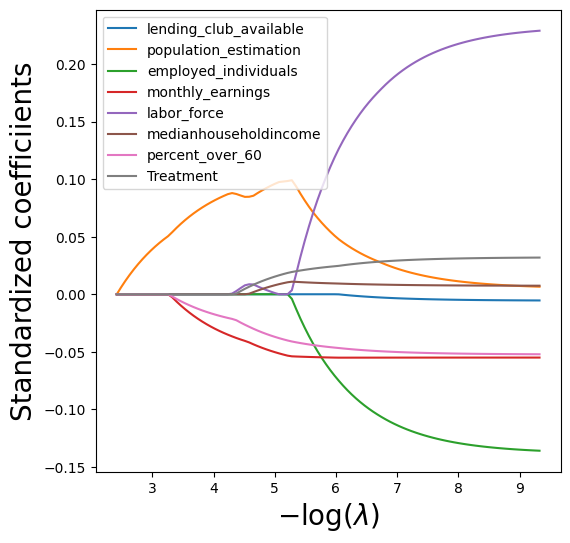

In [ ]:
path_fig, ax = subplots(figsize=(6,6))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);


In [ ]:
np.min(tuned_lasso.mse_path_.mean(1))

0.15997043273743417

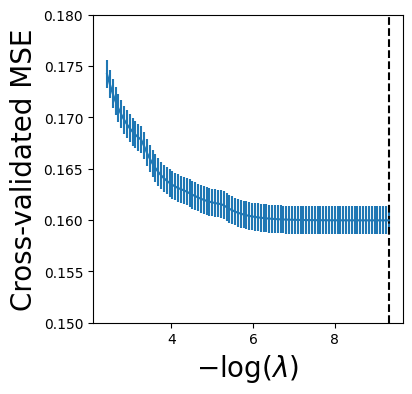

In [ ]:
lassoCV_fig, ax = subplots(figsize=(4,4))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([0.15,0.18])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [ ]:
tuned_lasso.coef_

array([-0.00538908,  0.00655949, -0.13601678, -0.05503582,  0.2290873 ,
        0.00743704, -0.05215745,  0.03188223])

In [ ]:
beta_hat_lasso = soln_path.loc[soln_path.index[39]]
lambda_lasso = lambdas[39]
beta_hat_lasso, lambda_lasso


(lending_club_available    0.000000
 population_estimation     0.098008
 employed_individuals     -0.000000
 monthly_earnings         -0.052421
 labor_force               0.000000
 medianhouseholdincome     0.009630
 percent_over_60          -0.039207
 Treatment                 0.017536
 Name: 5.140567081000602, dtype: float64,
 0.005854368870474206)

In [ ]:
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
pipe = Pipeline([('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([ 0.00087881, -0.00223573])

In [ ]:
pipe = Pipeline([('scaler', scaler),
                 ('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_


array([ 0.03727554, -0.02217269])

In [ ]:
param_grid = {'pca__n_components': range(1, 20)}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
55 fits failed out of a total of 95.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 652, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
  File "/usr/local/lib/python3.10

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

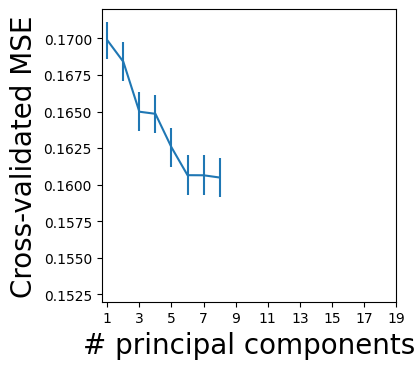

In [ ]:
pcr_fig, ax = subplots(figsize=(3.8,3.8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([0.152,0.172]);

In [ ]:
Xn = np.zeros((X.shape[0], 1))
cv_null = skm.cross_validate(linreg,
                             Xn,
                             Y,
                             cv=kfold,
                             scoring='neg_mean_squared_error')
-cv_null['test_score'].mean()


0.174260793530757

In [ ]:
pipe.named_steps['pca'].explained_variance_ratio_

array([0.42949282, 0.26603587])

In [ ]:
pls = PLSRegression(n_components=2,
                    scale=True)
pls.fit(X, Y)


PLSRegression()

In [ ]:
param_grid = {'n_components':range(1, 20)}
grid = skm.GridSearchCV(pls,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

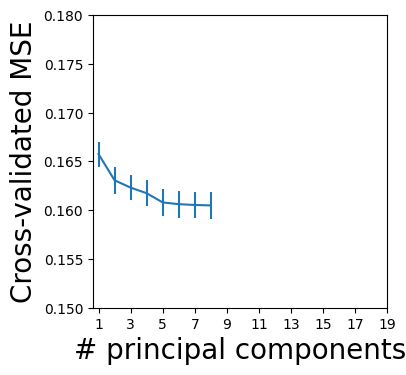

In [ ]:
pls_fig, ax = subplots(figsize=(3.8,3.8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([0.15,0.18]);